# <center>Data ingestion
</center>

In [1]:
import pandas as pd

columns = [
    "index",
    "Lever position (Lp)",
    "Ship speed (V) [knots]",
    "Gas Turbine shaft torque (GTT) [kN/m]",
    "Gas Turbine revolutions (GTn) [rpm]",
    "Gas Generator revolutions (GGn) [rpm]",
    "Starboard Propeller Torque (Ts) [kN/m]",
    "Port Propeller Torque (Tp) [kN/m]",
    "HP Turbine exit temperature (T48) [°C]",
    "Compressor inlet air temperature (T1) [°C]",
    "Compressor outlet air temperature (T2) [°C]",
    "HP Turbine exit pressure (P48) [bar]",
    "Compressor inlet air pressure (P1) [bar]",
    "Compressor outlet air pressure (P2) [bar]",
    "Exhaust gas pressure [bar]",
    "Turbine Injection Control (TIC) [%]",
    "Fuel flow (mf) [kg/s]",
    "Compressor decay coefficient",
    "Turbine decay coefficient"
]

df = pd.read_csv("./data/data.txt", 
                 sep=r'\s+', 
                 header=None)

df.index = df.index + 1
df.reset_index(inplace=True)
df.columns = columns

# Save to CSV
df.to_csv("./data/turbine_data.csv", index=False)


print("Converted Sensor logs txt (data.txt) --> csv (turbine_data.csv)\n")
print("First 5 rows of Unprocessed data")
print(df.head())



Converted Sensor logs txt (data.txt) --> csv (turbine_data.csv)

First 5 rows of Unprocessed data
   index  Lever position (Lp)  Ship speed (V) [knots]  \
0      1                1.138                     3.0   
1      2                2.088                     6.0   
2      3                3.144                     9.0   
3      4                4.161                    12.0   
4      5                5.140                    15.0   

   Gas Turbine shaft torque (GTT) [kN/m]  Gas Turbine revolutions (GTn) [rpm]  \
0                                289.964                             1349.489   
1                               6960.180                             1376.166   
2                               8379.229                             1386.757   
3                              14724.395                             1547.465   
4                              21636.432                             1924.313   

   Gas Generator revolutions (GGn) [rpm]  \
0                           

# <center> Data Cleaning & Transformation</center>

#### Handle nulls, outliers, smoothing

In [2]:
# Keep first column as integer
df['index'] = df['index'].astype(int)

# Select all other numeric columns exclude index
numeric_cols = df.columns[1:] 

# Fill numeric nulls with median
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Outlier using (IQR Method)
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)

# Smoothing values
df[numeric_cols] = df[numeric_cols].rolling(window=3, min_periods=1).mean()

# Round numbers to 2 decimals
df[numeric_cols] = df[numeric_cols].round(2)

print("Cleaned Data")
print(df.head())

Cleaned Data
   index  Lever position (Lp)  Ship speed (V) [knots]  \
0      1                 1.14                     3.0   
1      2                 1.61                     4.5   
2      3                 2.12                     6.0   
3      4                 3.13                     9.0   
4      5                 4.15                    12.0   

   Gas Turbine shaft torque (GTT) [kN/m]  Gas Turbine revolutions (GTn) [rpm]  \
0                                 289.96                              1349.49   
1                                3625.07                              1362.83   
2                                5209.79                              1370.80   
3                               10021.27                              1436.80   
4                               14913.35                              1619.51   

   Gas Generator revolutions (GGn) [rpm]  \
0                                6677.38   
1                                6752.92   
2                        

#### Derived Features : Temp_ratio_T48_T2, Temp_ratio_T1_P1, Torque_diff, RPM_ratio_GTn_GGn, Fuel_per_RPM, Total_Prop_Torque

In [3]:
import numpy as np
# Temperature-Pressure Ratios
df['Temp_ratio_T48_P48'] = (df['HP Turbine exit temperature (T48) [°C]'] / 
                           df['HP Turbine exit pressure (P48) [bar]']).round(2)
df['Temp_ratio_T1_P1'] = (df['Compressor inlet air temperature (T1) [°C]'] / 
                          df['Compressor inlet air pressure (P1) [bar]']).round(2)
df['Temp_ratio_T2_P2'] =  (df['Compressor outlet air temperature (T2) [°C]'] / 
                          df['Compressor outlet air pressure (P2) [bar]']).round(2)
# Torque Differentials
df['Torque_diff'] = (df['Starboard Propeller Torque (Ts) [kN/m]'] - 
                     df['Port Propeller Torque (Tp) [kN/m]']).round(2)

# Efficiency Indicators
df['RPM_ratio_GTn_GGn'] = (df['Gas Turbine revolutions (GTn) [rpm]'] / 
                           df['Gas Generator revolutions (GGn) [rpm]']).round(2)
df['Fuel_per_RPM'] = (df['Fuel flow (mf) [kg/s]'] / df['Gas Turbine revolutions (GTn) [rpm]']).round(5)

# Total Propeller Torque
df['Total_Prop_Torque'] = (df['Starboard Propeller Torque (Ts) [kN/m]'] +
                            df['Port Propeller Torque (Tp) [kN/m]']).round(2)

angular_velocity_rad_s = df['Gas Turbine revolutions (GTn) [rpm]'] * (2 * np.pi / 60)
df['Power_Proxy_kW'] = (
    df['Gas Turbine shaft torque (GTT) [kN/m]'] * angular_velocity_rad_s
).round(2)

# --- Total Decay Score ---
df['Total_decay_score'] = (
    (1 - df['Compressor decay coefficient']) + (1 - df['Turbine decay coefficient'])
).round(3)

pd.set_option('display.max_columns', None)
print("Cleaned Data with Derived Features")
print(df.head())


Cleaned Data with Derived Features
   index  Lever position (Lp)  Ship speed (V) [knots]  \
0      1                 1.14                     3.0   
1      2                 1.61                     4.5   
2      3                 2.12                     6.0   
3      4                 3.13                     9.0   
4      5                 4.15                    12.0   

   Gas Turbine shaft torque (GTT) [kN/m]  Gas Turbine revolutions (GTn) [rpm]  \
0                                 289.96                              1349.49   
1                                3625.07                              1362.83   
2                                5209.79                              1370.80   
3                               10021.27                              1436.80   
4                               14913.35                              1619.51   

   Gas Generator revolutions (GGn) [rpm]  \
0                                6677.38   
1                                6752.92   
2  

#### EDA (Exploratory Data Analysis)

- Summary statistics
- Null check
- Correlation heatmap
- Histograms
- Boxplots
- Pair plots


In [4]:
print("Summary Statistics ")
print(df.describe())

Summary Statistics 
              index  Lever position (Lp)  Ship speed (V) [knots]  \
count  11934.000000         11934.000000            11934.000000   
mean    5967.500000             5.166026               14.998115   
std     3445.193391             1.852686                5.479262   
min        1.000000             1.140000                3.000000   
25%     2984.250000             4.150000               12.000000   
50%     5967.500000             5.160000               15.000000   
75%     8950.750000             6.210000               18.000000   
max    11934.000000             8.220000               24.000000   

       Gas Turbine shaft torque (GTT) [kN/m]  \
count                           11934.000000   
mean                            27242.126459   
std                             15302.367750   
min                               289.960000   
25%                             14907.205000   
50%                             26910.115000   
75%                            

In [5]:
print("\nTotal Null Values ")
print(df.isnull().sum())



Total Null Values 
index                                          0
Lever position (Lp)                            0
Ship speed (V) [knots]                         0
Gas Turbine shaft torque (GTT) [kN/m]          0
Gas Turbine revolutions (GTn) [rpm]            0
Gas Generator revolutions (GGn) [rpm]          0
Starboard Propeller Torque (Ts) [kN/m]         0
Port Propeller Torque (Tp) [kN/m]              0
HP Turbine exit temperature (T48) [°C]         0
Compressor inlet air temperature (T1) [°C]     0
Compressor outlet air temperature (T2) [°C]    0
HP Turbine exit pressure (P48) [bar]           0
Compressor inlet air pressure (P1) [bar]       0
Compressor outlet air pressure (P2) [bar]      0
Exhaust gas pressure [bar]                     0
Turbine Injection Control (TIC) [%]            0
Fuel flow (mf) [kg/s]                          0
Compressor decay coefficient                   0
Turbine decay coefficient                      0
Temp_ratio_T48_P48                             0


In [6]:
numeric_cols = df.columns[1:]
corr_matrix = df[numeric_cols].corr()
print("\nCorrelation Matrix ")
print(corr_matrix)


Correlation Matrix 
                                             Lever position (Lp)  \
Lever position (Lp)                                     1.000000   
Ship speed (V) [knots]                                  0.999951   
Gas Turbine shaft torque (GTT) [kN/m]                   0.951117   
Gas Turbine revolutions (GTn) [rpm]                     0.955471   
Gas Generator revolutions (GGn) [rpm]                   0.991875   
Starboard Propeller Torque (Ts) [kN/m]                  0.948370   
Port Propeller Torque (Tp) [kN/m]                       0.948370   
HP Turbine exit temperature (T48) [°C]                  0.958208   
Compressor inlet air temperature (T1) [°C]                   NaN   
Compressor outlet air temperature (T2) [°C]             0.979643   
HP Turbine exit pressure (P48) [bar]                    0.952542   
Compressor inlet air pressure (P1) [bar]                     NaN   
Compressor outlet air pressure (P2) [bar]               0.960738   
Exhaust gas pressure [bar] 

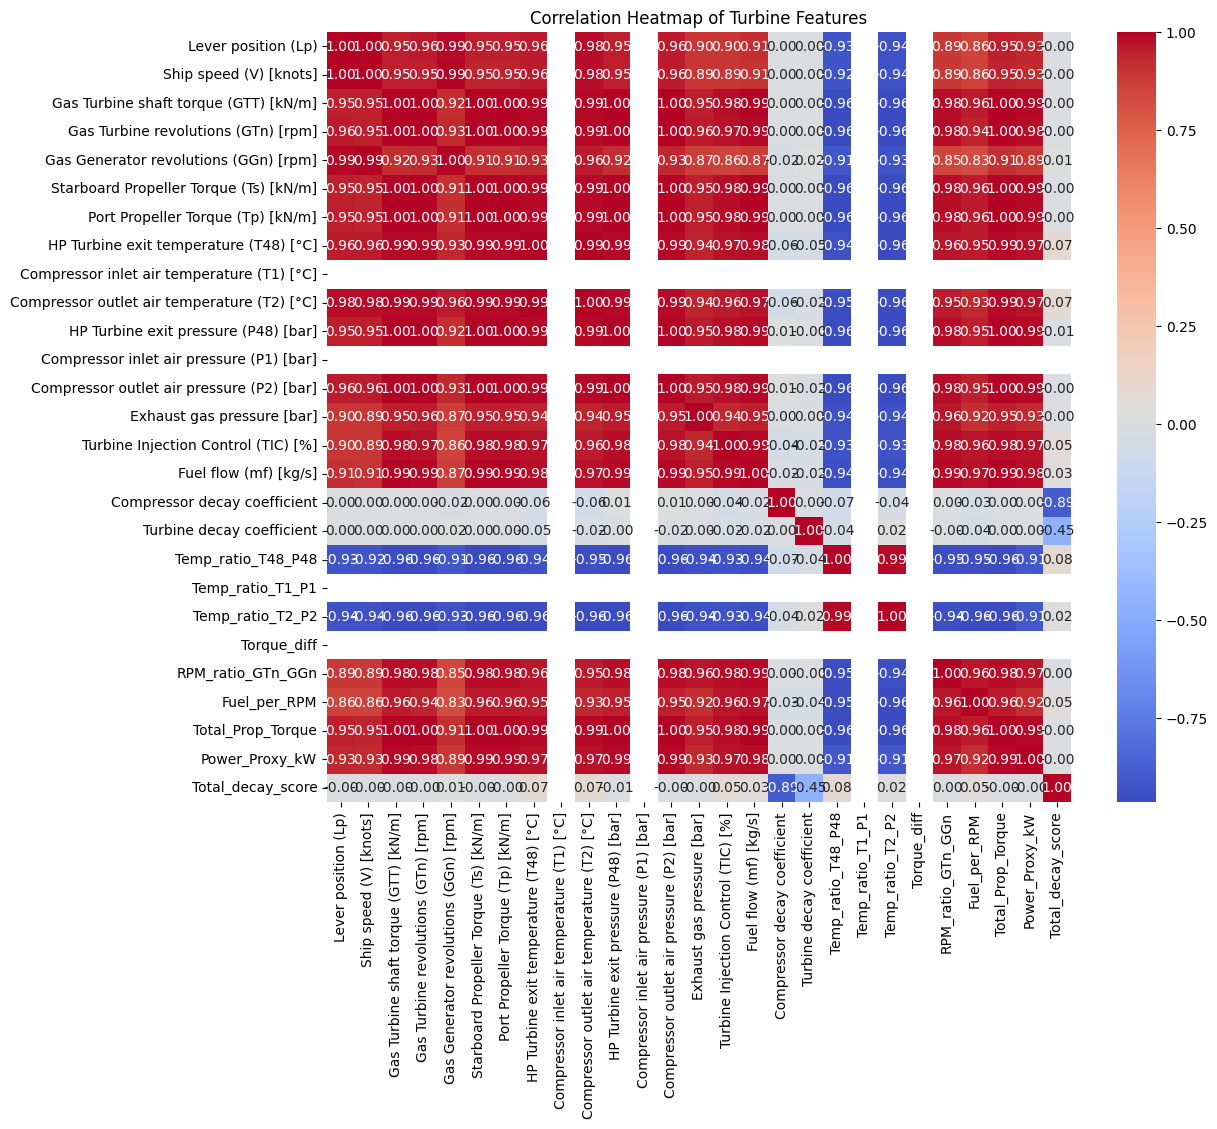

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Turbine Features")
plt.show()

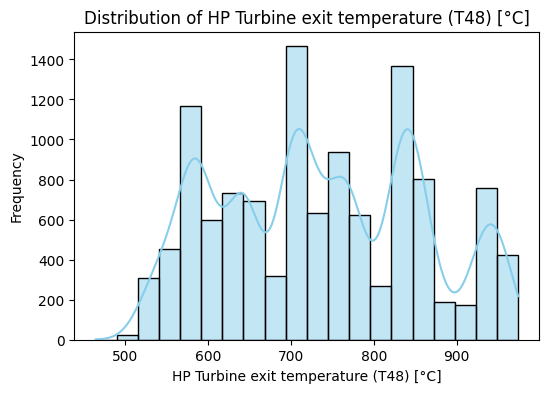

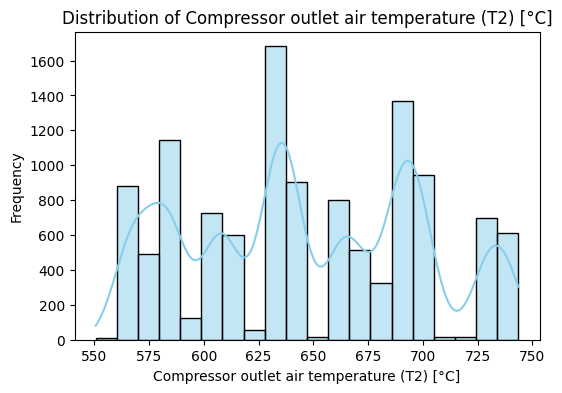

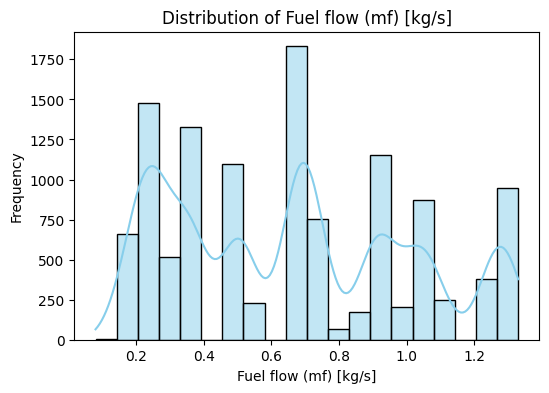

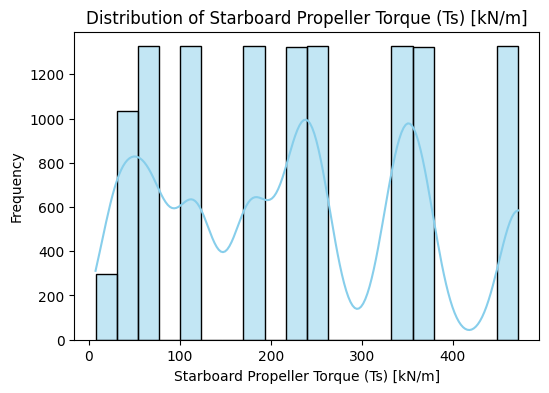

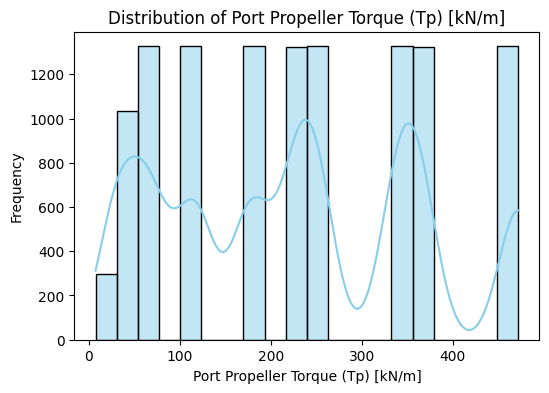

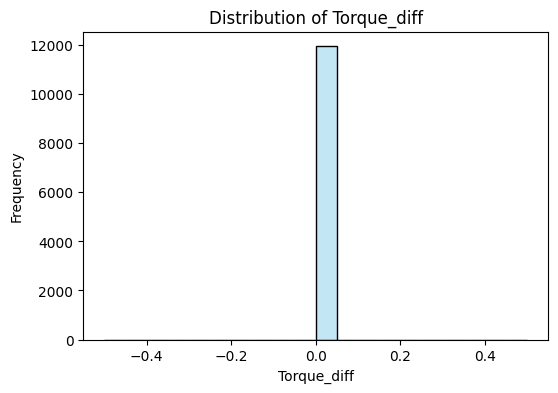

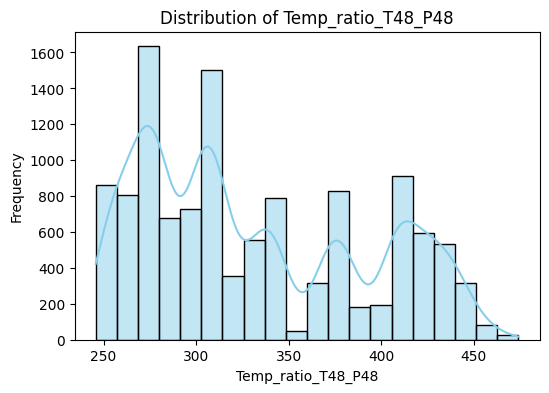

In [8]:
#Distributions of Key Columns
key_cols = ['HP Turbine exit temperature (T48) [°C]',
            'Compressor outlet air temperature (T2) [°C]',
            'Fuel flow (mf) [kg/s]',
            'Starboard Propeller Torque (Ts) [kN/m]',
            'Port Propeller Torque (Tp) [kN/m]',
            'Torque_diff',
            'Temp_ratio_T48_P48']

for col in key_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=20, kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


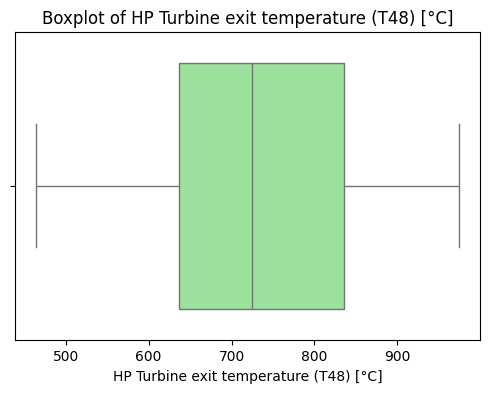

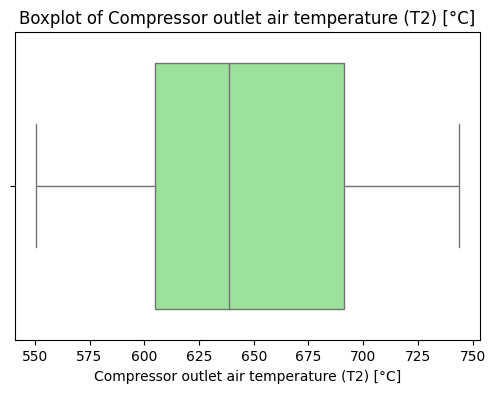

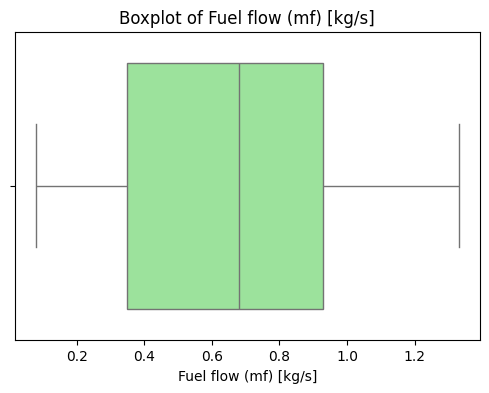

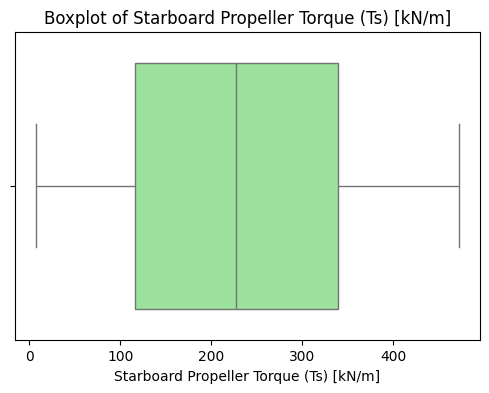

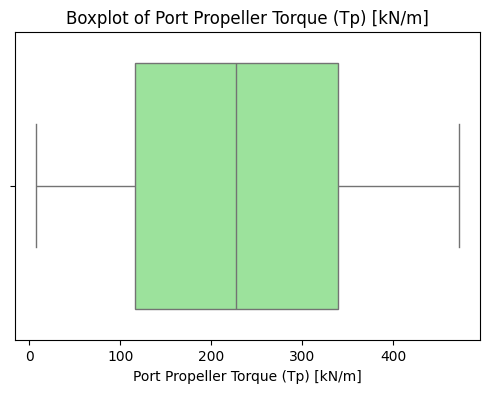

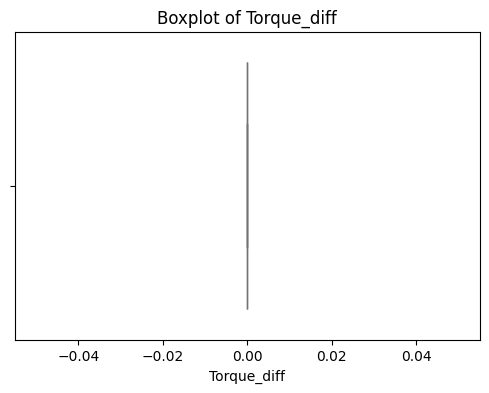

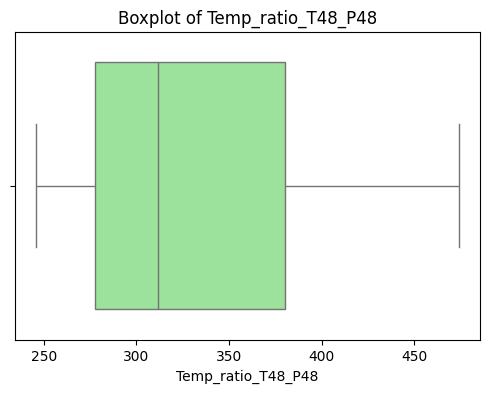

In [9]:
#Boxplots to detect remaining outliers
for col in key_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    plt.show()

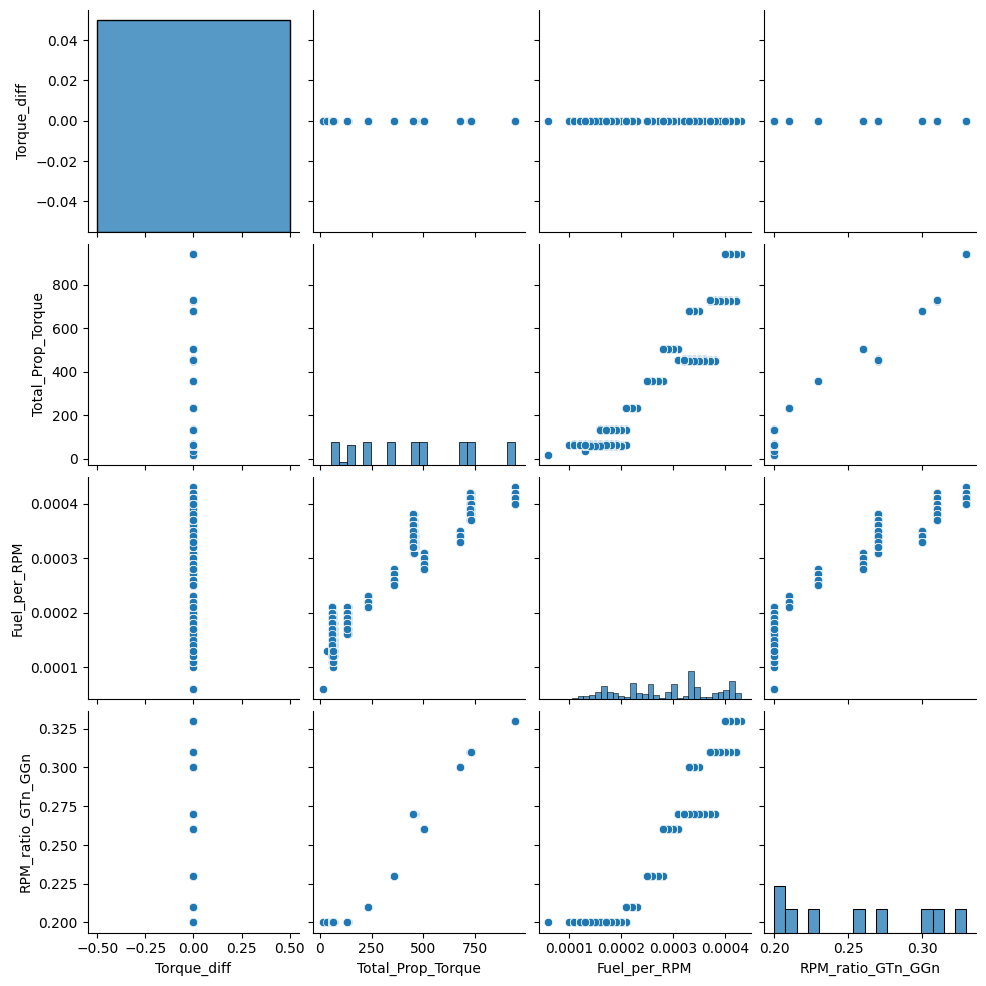

In [10]:
#Pairwise relationship
sns.pairplot(df[['Torque_diff', 'Total_Prop_Torque', 'Fuel_per_RPM', 'RPM_ratio_GTn_GGn']])
plt.show()

In [11]:
# Save df as cleaned csv
numeric_cols = df.columns[1:]  # exclude index
df[numeric_cols] = df[numeric_cols].round(2)

# Save to CSV again
df.to_csv("./data/turbine_data_cleaned.csv", index=False)
print("turbine_data_cleaned.csv created successfully")

turbine_data_cleaned.csv created successfully


In [12]:
import pandas as pd

df = pd.read_csv("./data/turbine_data_cleaned.csv")

# Rename columns to match SQL schema
df.rename(columns={
    "index": "id",  # optional if you don't want to keep CSV index
    "Lever position (Lp)": "lp",
    "Ship speed (V) [knots]": "v",
    "Gas Turbine shaft torque (GTT) [kN/m]": "gtt",
    "Gas Turbine revolutions (GTn) [rpm]": "gtn",
    "Gas Generator revolutions (GGn) [rpm]": "ggn",
    "Starboard Propeller Torque (Ts) [kN/m]": "ts",
    "Port Propeller Torque (Tp) [kN/m]": "tp",
    "HP Turbine exit temperature (T48) [°C]": "t48",
    "Compressor inlet air temperature (T1) [°C]": "t1",
    "Compressor outlet air temperature (T2) [°C]": "t2",
    "HP Turbine exit pressure (P48) [bar]": "p48",
    "Compressor inlet air pressure (P1) [bar]": "p1",
    "Compressor outlet air pressure (P2) [bar]": "p2",
    "Exhaust gas pressure [bar]": "pexh",
    "Turbine Injection Control (TIC) [%]": "tic",
    "Fuel flow (mf) [kg/s]": "mf",
    "Compressor decay coefficient": "decay_coeff_comp",
    "Turbine decay coefficient": "decay_coeff_turbine",
    "Temp_ratio_T48_P48": "temp_ratio_t48_p48",
    "Temp_ratio_T1_P1": "temp_ratio_t1_p1",
    "Temp_ratio_T2_P2": "temp_ratio_t2_p2",
    "Torque_diff": "torque_diff",
    "RPM_ratio_GTn_GGn": "rpm_ratio_gtn_ggn",
    "Fuel_per_RPM": "fuel_per_rpm",
    "Total_Prop_Torque": "total_prop_torque",
    "Power_Proxy_kW": "power_proxy_kw",
    "Total_decay_score": "total_decay_score"
}, inplace=True)

# Save the renamed DataFrame to a new CSV (or overwrite existing one)
df.to_csv("./data/turbine_data_renamed.csv", index=False)
print("turbine_data_renamed.csv created successfully")

turbine_data_renamed.csv created successfully


# <center>SQL & Exploratory Analysis</center>

#### SQL Table Creation

In [13]:
#SQlite database connection

import sqlite3
import pandas as pd
from sqlalchemy import create_engine

# Option 1: Using sqlite3 directly
conn = sqlite3.connect("./data/turbine_data.db")  # Creates DB file locally
cursor = conn.cursor()


#### turbine_metadata, sensor_reading Table schema

In [14]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("./data/turbine_data.db")
cursor = conn.cursor()

# Drop tables if they exist to start fresh
cursor.execute("DROP TABLE IF EXISTS sensor_readings;")
cursor.execute("DROP TABLE IF EXISTS turbine_metadata;")

conn.commit()

# Create the turbine_metadata table first, as it's the referenced table
create_metadata_table_query = """
CREATE TABLE turbine_metadata (
    turbine_id INTEGER PRIMARY KEY,
    location TEXT,
    manufacturer TEXT,
    model TEXT
);
"""
cursor.execute(create_metadata_table_query)
conn.commit()
print("Table 'turbine_metadata' created successfully.\n")

# Create the sensor_readings table with the foreign key constraint
create_sensor_readings_table_query = """
CREATE TABLE sensor_readings (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    timestamp TEXT,
    lp FLOAT,
    v FLOAT,
    gtt FLOAT,
    gtn FLOAT,
    ggn FLOAT,
    ts FLOAT,
    tp FLOAT,
    t48 FLOAT,
    t1 FLOAT,
    t2 FLOAT,
    p48 FLOAT,
    p1 FLOAT,
    p2 FLOAT,
    pexh FLOAT,
    tic FLOAT,
    mf FLOAT,
    decay_coeff_comp FLOAT,
    decay_coeff_turbine FLOAT,
    turbine_id INTEGER,
    FOREIGN KEY (turbine_id) REFERENCES turbine_metadata(turbine_id)
);
"""
cursor.execute(create_sensor_readings_table_query)
conn.commit()
print("Table 'sensor_readings' created successfully with foreign key.\n")

# List all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables:", tables)

# Show schema of a specific table
cursor.execute("PRAGMA table_info(sensor_readings);")
schema = cursor.fetchall()
print("\nSchema for sensor_readings:\n")
print("(cid, column_name, data_type, not_null, default_value, primary_key)")
for column in schema:
    print(column)

conn.close()

Table 'turbine_metadata' created successfully.

Table 'sensor_readings' created successfully with foreign key.

Tables: [('turbine_metadata',), ('sensor_readings',), ('sqlite_sequence',)]

Schema for sensor_readings:

(cid, column_name, data_type, not_null, default_value, primary_key)
(0, 'id', 'INTEGER', 0, None, 1)
(1, 'timestamp', 'TEXT', 0, None, 0)
(2, 'lp', 'FLOAT', 0, None, 0)
(3, 'v', 'FLOAT', 0, None, 0)
(4, 'gtt', 'FLOAT', 0, None, 0)
(5, 'gtn', 'FLOAT', 0, None, 0)
(6, 'ggn', 'FLOAT', 0, None, 0)
(7, 'ts', 'FLOAT', 0, None, 0)
(8, 'tp', 'FLOAT', 0, None, 0)
(9, 't48', 'FLOAT', 0, None, 0)
(10, 't1', 'FLOAT', 0, None, 0)
(11, 't2', 'FLOAT', 0, None, 0)
(12, 'p48', 'FLOAT', 0, None, 0)
(13, 'p1', 'FLOAT', 0, None, 0)
(14, 'p2', 'FLOAT', 0, None, 0)
(15, 'pexh', 'FLOAT', 0, None, 0)
(16, 'tic', 'FLOAT', 0, None, 0)
(17, 'mf', 'FLOAT', 0, None, 0)
(18, 'decay_coeff_comp', 'FLOAT', 0, None, 0)
(19, 'decay_coeff_turbine', 'FLOAT', 0, None, 0)
(20, 'turbine_id', 'INTEGER', 0, None,

#### turbine_metadata table schema

In [15]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("./data/turbine_data.db")
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS turbine_metadata;")
conn.commit()
# Create turbine_metadata table
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='turbine_metadata';")
if cursor.fetchone():
    print("Table 'turbine_metadata' already exists.")
else:
    create_metadata_query = """
    CREATE TABLE turbine_metadata (
        turbine_id INTEGER PRIMARY KEY,
        location TEXT,
        manufacturer TEXT,
        model TEXT,
        install_date DATE
    );
    """
    cursor.execute(create_metadata_query)
    conn.commit()
    print("Table 'turbine_metadata' created successfully.")



# List all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables:", tables)

# Show schema of a specific table
cursor.execute("PRAGMA table_info(turbine_metadata);")
schema = cursor.fetchall()
print("\nSchema for turbine_metadata:\n")
print("(cid, column_name, data_type, not_null, default_value, primary_key)")
for column in schema:
    print(column)

conn.close()

Table 'turbine_metadata' created successfully.
Tables: [('sensor_readings',), ('sqlite_sequence',), ('turbine_metadata',)]

Schema for turbine_metadata:

(cid, column_name, data_type, not_null, default_value, primary_key)
(0, 'turbine_id', 'INTEGER', 0, None, 1)
(1, 'location', 'TEXT', 0, None, 0)
(2, 'manufacturer', 'TEXT', 0, None, 0)
(3, 'model', 'TEXT', 0, None, 0)
(4, 'install_date', 'DATE', 0, None, 0)


#### alert table schema

In [16]:
import sqlite3

conn = sqlite3.connect("./data/turbine_data.db")
cursor = conn.cursor()

# Drop alerts table if it exists
cursor.execute("DROP TABLE IF EXISTS alerts;")
print("Existing 'alerts' table dropped (if it existed).")

# Create alerts table
create_alerts_query = """
CREATE TABLE alerts (
    alert_id INTEGER PRIMARY KEY AUTOINCREMENT,
    turbine_id INTEGER,
    timestamp TEXT,
    metric TEXT,
    alert_type TEXT,
    severity TEXT,
    actual_value FLOAT,
    threshold_value FLOAT,
    description TEXT,
    FOREIGN KEY (turbine_id) REFERENCES turbine_metadata(turbine_id)
);
"""
cursor.execute(create_alerts_query)
conn.commit()
print("Table 'alerts' created successfully.")

# List all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables:", tables)

# Show schema of alerts table
cursor.execute("PRAGMA table_info(alerts);")
schema = cursor.fetchall()
print("\nSchema for alerts:\n")
print("(cid, column_name, data_type, not_null, default_value, primary_key)")
for column in schema:
    print(column)

conn.close()

Existing 'alerts' table dropped (if it existed).
Table 'alerts' created successfully.
Tables: [('sensor_readings',), ('sqlite_sequence',), ('turbine_metadata',), ('alerts',)]

Schema for alerts:

(cid, column_name, data_type, not_null, default_value, primary_key)
(0, 'alert_id', 'INTEGER', 0, None, 1)
(1, 'turbine_id', 'INTEGER', 0, None, 0)
(2, 'timestamp', 'TEXT', 0, None, 0)
(3, 'metric', 'TEXT', 0, None, 0)
(4, 'alert_type', 'TEXT', 0, None, 0)
(5, 'severity', 'TEXT', 0, None, 0)
(6, 'actual_value', 'FLOAT', 0, None, 0)
(7, 'threshold_value', 'FLOAT', 0, None, 0)
(8, 'description', 'TEXT', 0, None, 0)


#### Insert sensor_reading table values

In [17]:
import pandas as pd
import sqlite3
from datetime import datetime, timedelta

# --- 1. Data Loading and Preparation ---
# Load the CSV
try:
    df = pd.read_csv("./data/turbine_data_renamed.csv")
except FileNotFoundError:
    print("Error: The file 'turbine_data_renamed.csv' was not found.")
    exit()

# Select the columns needed for the database table
# Ensure the columns in this list match your CSV and the desired table schema
raw_columns = [
    "lp","v","gtt","gtn","ggn","ts","tp","t48","t1","t2",
    "p48","p1","p2","pexh","tic","mf","decay_coeff_comp","decay_coeff_turbine"
]
df_raw = df[raw_columns].copy()

# Generate incremental timestamps
start_time = datetime(2025, 9, 21, 10, 0, 0)
time_interval = timedelta(seconds=10)
df_raw['timestamp'] = [(start_time + i*time_interval).strftime("%Y-%m-%d %H:%M:%S")
                         for i in range(len(df_raw))]

# Add the 'turbine_id' column with a value of 1 for all rows
df_raw['turbine_id'] = 1

# Reorder columns to match SQLite schema: timestamp first
ordered_columns = [
    "timestamp","lp","v","gtt","gtn","ggn","ts","tp","t48","t1","t2",
    "p48","p1","p2","pexh","tic","mf","decay_coeff_comp","decay_coeff_turbine",
    "turbine_id"
]
df_raw = df_raw[ordered_columns]

# --- 2. Database Connection and Table Creation ---
conn = sqlite3.connect("./data/turbine_data.db")
cursor = conn.cursor()

# Drop the table if it already exists to ensure a clean start
cursor.execute("DROP TABLE IF EXISTS sensor_readings;")
conn.commit()

# Create the table with all the necessary columns, including turbine_id
create_table_query = """
CREATE TABLE sensor_readings (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    timestamp TEXT,
    lp FLOAT,
    v FLOAT,
    gtt FLOAT,
    gtn FLOAT,
    ggn FLOAT,
    ts FLOAT,
    tp FLOAT,
    t48 FLOAT,
    t1 FLOAT,
    t2 FLOAT,
    p48 FLOAT,
    p1 FLOAT,
    p2 FLOAT,
    pexh FLOAT,
    tic FLOAT,
    mf FLOAT,
    decay_coeff_comp FLOAT,
    decay_coeff_turbine FLOAT,
    turbine_id INTEGER
);
"""
cursor.execute(create_table_query)
conn.commit()
print("Table 'sensor_readings' created successfully.\n")

# --- 3. Data Insertion ---
# Use pandas to_sql to insert the DataFrame into the table
df_raw.to_sql("sensor_readings", conn, if_exists="append", index=False)

print(f"{len(df_raw)} rows inserted into 'sensor_readings' table.\n")

# --- 4. Verification ---
# Preview the first 5 rows to confirm correct insertion
query = "SELECT * FROM sensor_readings LIMIT 5;"
df_preview = pd.read_sql(query, conn)
print(df_preview)

conn.close()

Table 'sensor_readings' created successfully.

11934 rows inserted into 'sensor_readings' table.

   id            timestamp    lp     v       gtt      gtn      ggn      ts  \
0   1  2025-09-21 10:00:00  1.14   3.0    289.96  1349.49  6677.38    7.58   
1   2  2025-09-21 10:00:10  1.61   4.5   3625.07  1362.83  6752.92   17.89   
2   3  2025-09-21 10:00:20  2.12   6.0   5209.79  1370.80  6872.55   32.05   
3   4  2025-09-21 10:00:30  3.13   9.0  10021.27  1436.80  7244.30   67.45   
4   5  2025-09-21 10:00:40  4.15  12.0  14913.35  1619.51  7799.74  116.48   

       tp     t48     t1      t2   p48   p1    p2  pexh    tic    mf  \
0    7.58  464.01  288.0  550.56  1.10  1.0  5.95  1.02   7.14  0.08   
1   17.89  549.70  288.0  566.11  1.21  1.0  6.61  1.02   8.90  0.18   
2   32.05  568.47  288.0  573.27  1.27  1.0  6.93  1.02  10.29  0.21   
3   67.45  634.29  288.0  594.37  1.46  1.0  7.95  1.02  13.95  0.30   
4  116.48  666.32  288.0  615.69  1.71  1.0  9.26  1.02  19.19  0.38   



#### Insert turbine_metadata table values

In [18]:
import sqlite3
from datetime import datetime

# Connect to SQLite
conn = sqlite3.connect("./data/turbine_data.db")
cursor = conn.cursor()

# Example turbine metadata
turbine_data = [
    (1, "Singapore Port", "GE", "GTX-1000", "2023-01-15"),
    (2, "Singapore Port", "Siemens", "ST-2000", "2022-08-10"),
    (3, "Singapore Port", "Rolls-Royce", "RR-Turbo", "2024-03-05")
]

# Insert into turbine_metadata table
insert_query = """
INSERT OR IGNORE INTO turbine_metadata
(turbine_id, location, manufacturer, model, install_date)
VALUES (?, ?, ?, ?, ?)
"""

cursor.executemany(insert_query, turbine_data)
conn.commit()
print("(turbine_id, location, manufacturer, model, install_date)")
# Verify insertion
cursor.execute("SELECT * FROM turbine_metadata;")
rows = cursor.fetchall()
for row in rows:
    print(row)

# Close connection
conn.close()


(turbine_id, location, manufacturer, model, install_date)
(1, 'Singapore Port', 'GE', 'GTX-1000', '2023-01-15')
(2, 'Singapore Port', 'Siemens', 'ST-2000', '2022-08-10')
(3, 'Singapore Port', 'Rolls-Royce', 'RR-Turbo', '2024-03-05')


#### Insert Alert table values

In [19]:
import sqlite3
from datetime import datetime

# Connect to SQLite
conn = sqlite3.connect("./data/turbine_data.db")
cursor = conn.cursor()

# Fetch sensor readings
query = "SELECT rowid, timestamp, ts, tp, t48, mf, turbine_id FROM sensor_readings;"
cursor.execute(query)
rows = cursor.fetchall()

alerts_to_insert = []

# Define thresholds (with warning/critical if needed)
THRESHOLDS = {
    "t48": {"warning": 700, "critical": 900},      
    "mf": {"warning": 0.2, "critical": 0.3},       
    "ts": {"warning": 40, "critical": 50},         
    "tp": {"warning": 40, "critical": 50}          
}

# Generate alerts
for row in rows:
    sensor_id, timestamp, ts, tp, t48, mf, turbine_id = row

    # T48
    if t48 > THRESHOLDS["t48"]["critical"]:
        severity = "Critical"
    elif t48 > THRESHOLDS["t48"]["warning"]:
        severity = "Warning"
    else:
        severity = None

    if severity:
        alerts_to_insert.append((
            turbine_id, timestamp, "t48", "Overheat", severity, t48, THRESHOLDS["t48"]["critical"],
            f"T48={t48}°C exceeds threshold"
        ))

    # Fuel Flow
    if mf > THRESHOLDS["mf"]["critical"]:
        severity = "Critical"
    elif mf > THRESHOLDS["mf"]["warning"]:
        severity = "Warning"
    else:
        severity = None

    if severity:
        alerts_to_insert.append((
            turbine_id, timestamp, "mf", "High Fuel Flow", severity, mf, THRESHOLDS["mf"]["critical"],
            f"mf={mf} kg/s exceeds threshold"
        ))

    # Propeller Torque (ts and tp)
    for metric, value in [("ts", ts), ("tp", tp)]:
        if value > THRESHOLDS[metric]["critical"]:
            severity = "Critical"
        elif value > THRESHOLDS[metric]["warning"]:
            severity = "Warning"
        else:
            severity = None

        if severity:
            alerts_to_insert.append((
                turbine_id, timestamp, metric, "High Propeller Torque", severity, value, THRESHOLDS[metric]["critical"],
                f"{metric}={value} exceeds threshold"
            ))

# Insert alerts
insert_query = """
INSERT INTO alerts (
    turbine_id, timestamp, metric, alert_type, severity, actual_value, threshold_value, description
) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
"""
cursor.executemany(insert_query, alerts_to_insert)
conn.commit()

print(f"{len(alerts_to_insert)} alerts inserted into 'alerts' table.\n")

# Verify first 5 alerts
cursor.execute("SELECT * FROM alerts LIMIT 5;")
print("(alert_id, turbine_id, timestamp, metric, alert_type, severity, actual_value, threshold_value, description)")
for alert in cursor.fetchall():
    print(alert)

conn.close()

39807 alerts inserted into 'alerts' table.

(alert_id, turbine_id, timestamp, metric, alert_type, severity, actual_value, threshold_value, description)
(1, 1, '2025-09-21 10:00:20', 'mf', 'High Fuel Flow', 'Warning', 0.21, 0.3, 'mf=0.21 kg/s exceeds threshold')
(2, 1, '2025-09-21 10:00:30', 'mf', 'High Fuel Flow', 'Warning', 0.3, 0.3, 'mf=0.3 kg/s exceeds threshold')
(3, 1, '2025-09-21 10:00:30', 'ts', 'High Propeller Torque', 'Critical', 67.45, 50.0, 'ts=67.45 exceeds threshold')
(4, 1, '2025-09-21 10:00:30', 'tp', 'High Propeller Torque', 'Critical', 67.45, 50.0, 'tp=67.45 exceeds threshold')
(5, 1, '2025-09-21 10:00:40', 'mf', 'High Fuel Flow', 'Critical', 0.38, 0.3, 'mf=0.38 kg/s exceeds threshold')


## SQL Transformations (Joins, Filters, Aggregations)

#### Joins

In [20]:
# Load extension of ipython-sql
%load_ext sql
# connect to sqlite
%sql sqlite:///./data/turbine_data.db
%config SqlMagic.style = 'PLAIN_COLUMNS'

In [21]:
%config SqlMagic.autocommit = True
%config SqlMagic.autopandas = True

In [22]:
import pandas as pd
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('./data/turbine_data.db')

# Define your SQL query
query = """
SELECT
    s.id,
    s.timestamp,
    s.lp,
    s.v,
    s.gtt,
    s.gtn,
    s.ggn,
    s.ts,
    s.tp,
    s.t48,
    s.mf,
    t.location,
    t.manufacturer,
    t.model
FROM sensor_readings AS s
JOIN turbine_metadata AS t
ON s.turbine_id = t.turbine_id
WHERE s.turbine_id = 1;
"""

# Execute the query and load results into a Pandas DataFrame
df_result = pd.read_sql(query, conn)

# Print the resulting DataFrame
print(df_result)

# Close the database connection
conn.close()

          id            timestamp    lp     v       gtt      gtn      ggn  \
0          1  2025-09-21 10:00:00  1.14   3.0    289.96  1349.49  6677.38   
1          2  2025-09-21 10:00:10  1.61   4.5   3625.07  1362.83  6752.92   
2          3  2025-09-21 10:00:20  2.12   6.0   5209.79  1370.80  6872.55   
3          4  2025-09-21 10:00:30  3.13   9.0  10021.27  1436.80  7244.30   
4          5  2025-09-21 10:00:40  4.15  12.0  14913.35  1619.51  7799.74   
...      ...                  ...   ...   ...       ...      ...      ...   
11929  11930  2025-09-22 19:08:10  4.15  12.0  14906.30  1619.51  7754.30   
11930  11931  2025-09-22 19:08:20  5.16  15.0  22035.49  1926.18  8333.33   
11931  11932  2025-09-22 19:08:30  6.15  18.0  30130.67  2303.05  8797.08   
11932  11933  2025-09-22 19:08:40  7.18  21.0  39919.89  2690.74  9073.84   
11933  11934  2025-09-22 19:08:50  8.22  24.0  54257.19  3108.63  9388.04   

           ts      tp     t48    mf        location manufacturer     model 

#### Filter Data

In [23]:
%config SqlMagic.style = 'PLAIN_GRID'

In [24]:
import sqlite3
import pandas as pd

# Connect to SQLite
conn = sqlite3.connect("./data/turbine_data.db")

# Query 1: Fuel flow > 0.3
df1 = pd.read_sql("SELECT * FROM sensor_readings WHERE mf > 0.3;", conn)

# Query 2: Time range filter
df2 = pd.read_sql("""
    SELECT * 
    FROM sensor_readings
    WHERE timestamp BETWEEN '2025-09-21 10:00:00' AND '2025-09-21 10:00:30';
""", conn)

# Show preview
print("Show all records where mf > 0.3")
print(df1.head())
print("="*100)
print("\nShow all records where timestamp BETWEEN '2025-09-21 10:00:00' AND '2025-09-21 10:00:30")
print(df2.head())

conn.close()


Show all records where mf > 0.3
   id            timestamp    lp     v       gtt      gtn      ggn      ts  \
0   5  2025-09-21 10:00:40  4.15  12.0  14913.35  1619.51  7799.74  116.48   
1   6  2025-09-21 10:00:50  5.16  15.0  22051.19  1926.39  8371.92  178.45   
2   7  2025-09-21 10:01:00  6.15  18.0  30137.11  2303.27  8818.52  251.22   
3   8  2025-09-21 10:01:10  7.18  21.0  39923.91  2691.02  9093.12  338.78   
4   9  2025-09-21 10:01:20  8.22  24.0  54247.44  3108.68  9409.84  471.66   

       tp     t48     t1      t2   p48   p1     p2  pexh    tic    mf  \
0  116.48  666.32  288.0  615.69  1.71  1.0   9.26  1.02  19.19  0.38   
1  178.45  731.13  288.0  645.30  2.08  1.0  11.19  1.03  26.75  0.53   
2  251.22  795.56  288.0  674.00  2.51  1.0  13.41  1.03  36.00  0.71   
3  338.78  869.10  288.0  706.04  3.01  1.0  15.89  1.03  48.03  0.95   
4  471.66  974.22  288.0  743.61  3.68  1.0  19.04  1.04  66.40  1.33   

   decay_coeff_comp  decay_coeff_turbine  turbine_id  
0    

#### Aggregations

#### Fuel usage over time (hourly)

            hour  avg_fuel_flow  total_fuel
0  2025-09-21 10       0.680250      244.89
1  2025-09-21 11       0.675222      243.08
2  2025-09-21 12       0.680222      244.88
3  2025-09-21 13       0.672389      242.06
4  2025-09-21 14       0.675722      243.26


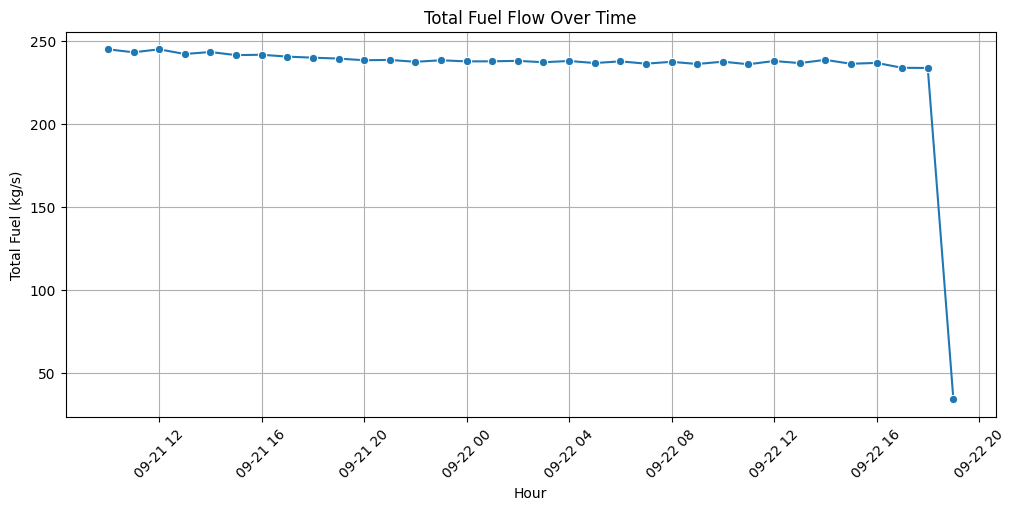

In [25]:
import pandas as pd
import sqlite3

# Connect to database
conn = sqlite3.connect("./data/turbine_data.db")

# Aggregated fuel usage by hour
df1 = pd.read_sql("""
    SELECT 
        strftime('%Y-%m-%d %H', timestamp) AS hour,
        AVG(mf) AS avg_fuel_flow,
        SUM(mf) AS total_fuel
    FROM sensor_readings
    GROUP BY hour
    ORDER BY hour;
""", conn)

# Preview
print(df1.head())

conn.close()


# Convert hour to datetime
df1['hour'] = pd.to_datetime(df1['hour'])

# Plot total fuel over time
plt.figure(figsize=(12,5))
sns.lineplot(data=df1, x='hour', y='total_fuel', marker='o')
plt.title("Total Fuel Flow Over Time")
plt.xlabel("Hour")
plt.ylabel("Total Fuel (kg/s)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### Turbine efficiency proxy

             timestamp  efficiency_proxy
0  2025-09-21 10:00:00     255728.355000
1  2025-09-21 10:00:10     270900.318889
2  2025-09-21 10:00:20     418420.380952
3  2025-09-21 10:00:30     646081.066667
4  2025-09-21 10:00:40     992844.867368


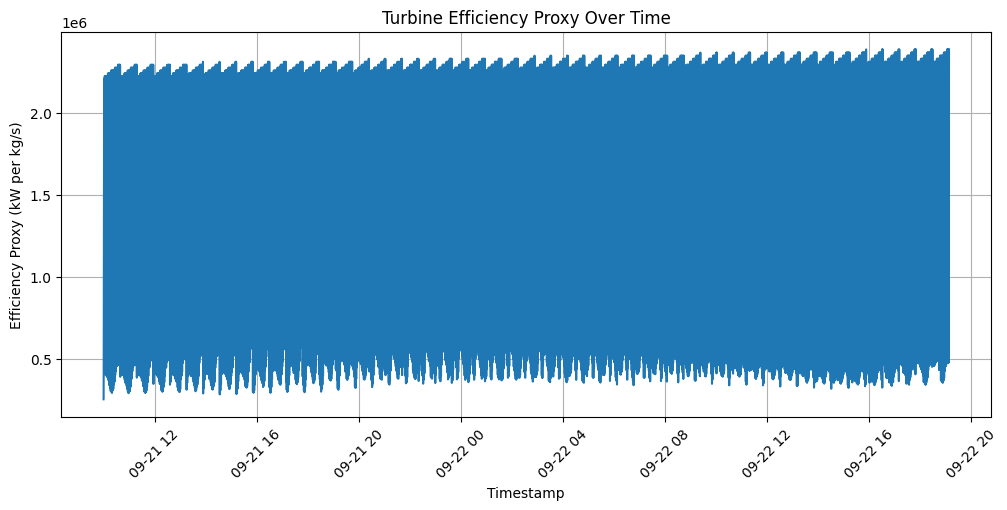

In [26]:
import pandas as pd
import sqlite3

# Connect to database
conn = sqlite3.connect("./data/turbine_data.db")

# Compute turbine efficiency proxy
df_efficiency = pd.read_sql("""
    SELECT 
        timestamp,
        ((ts + tp) * gtn / mf) AS efficiency_proxy
    FROM sensor_readings
    WHERE mf > 0
    ORDER BY timestamp;
""", conn)

# Preview first 5 rows
print(df_efficiency.head())

conn.close()

df_efficiency['timestamp'] = pd.to_datetime(df_efficiency['timestamp'])

# Plot efficiency proxy
plt.figure(figsize=(12,5))
sns.lineplot(data=df_efficiency, x='timestamp', y='efficiency_proxy')
plt.title("Turbine Efficiency Proxy Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Efficiency Proxy (kW per kg/s)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### Alerts per turbine

Total Alerts:
   total_alerts
0         39807

Alerts per Turbine and Alert Type:
   turbine_id             alert_type  severity  alert_count
0           1         High Fuel Flow  Critical         9280
1           1         High Fuel Flow   Warning         1992
2           1  High Propeller Torque  Critical        21212
3           1               Overheat  Critical         1346
4           1               Overheat   Warning         5977

Top 5 Alert Types:
              alert_type  alert_count
0  High Propeller Torque        21212
1         High Fuel Flow        11272
2               Overheat         7323


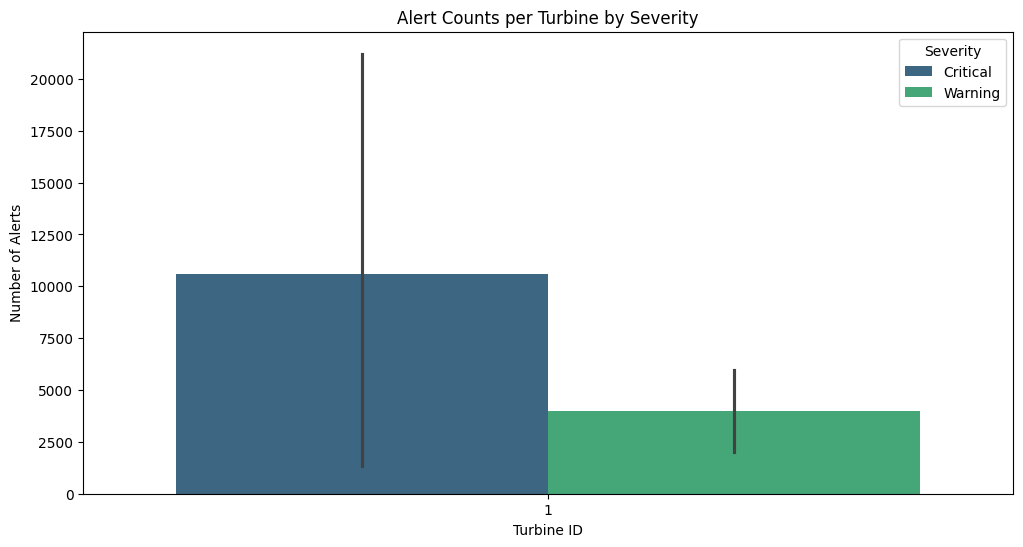

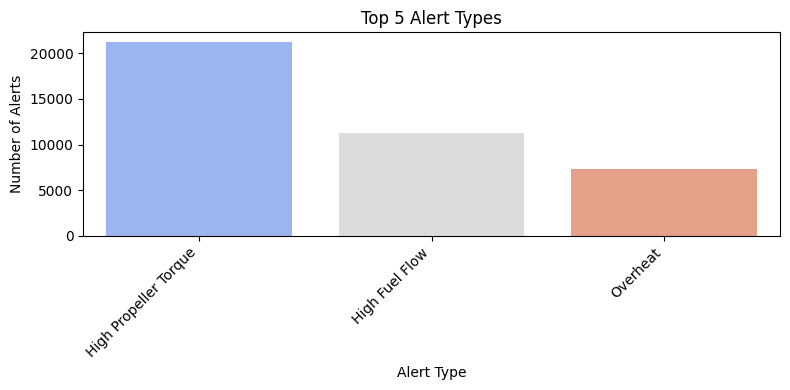

In [27]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to SQLite database
conn = sqlite3.connect("./data/turbine_data.db")

# Total number of alerts
df_total_alert = pd.read_sql("""
    SELECT COUNT(*) AS total_alerts
    FROM alerts;
""", conn)

# Alerts count per turbine and alert type
df_efficiency = pd.read_sql("""
    SELECT turbine_id, alert_type, severity, COUNT(*) AS alert_count
    FROM alerts
    GROUP BY turbine_id, alert_type, severity
    ORDER BY turbine_id, alert_type, severity;
""", conn)

# Corrected query: Top 5 most frequent alert types
df_top_alerts = pd.read_sql("""
    SELECT alert_type, COUNT(*) AS alert_count
    FROM alerts
    GROUP BY alert_type
    ORDER BY alert_count DESC
    LIMIT 5;
""", conn)

conn.close()

# Print summaries
print("Total Alerts:")
print(df_total_alert)
print("\nAlerts per Turbine and Alert Type:")
print(df_efficiency.head())
print("\nTop 5 Alert Types:")
print(df_top_alerts)

# Plot: Alerts per turbine by alert type and severity
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_efficiency,
    x='turbine_id',
    y='alert_count',
    hue='severity',
    palette='viridis'
)
plt.title("Alert Counts per Turbine by Severity")
plt.xlabel("Turbine ID")
plt.ylabel("Number of Alerts")
plt.legend(title="Severity")
plt.show()

# Corrected plot: Top 5 alert types plot
plt.figure(figsize=(8,4))
sns.barplot(
    data=df_top_alerts,
    x='alert_type',
    y='alert_count',
    hue='alert_type', # Fix: Pass the 'x' variable to 'hue'
    palette='coolwarm',
    legend=False # Fix: Set legend to False
)
plt.title("Top 5 Alert Types")
plt.xlabel("Alert Type")
plt.ylabel("Number of Alerts")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
import sqlite3

# Connect to database
conn = sqlite3.connect("./data/turbine_data.db")
df_total_alert = pd.read_sql(
    """
    SELECT *
FROM sensor_readings;

    """
,conn)

# Compute turbine efficiency proxy
df_efficiency = pd.read_sql("""
   SELECT * from turbine_metadata

""", conn)

df1 = pd.read_sql("""
   SELECT * from alerts

""", conn)
print(df_total_alert.tail(6))
print("\n")
# Preview first 5 rows
print(df_efficiency.tail())
print(df1.tail())

          id            timestamp    lp     v       gtt      gtn      ggn  \
11928  11929  2025-09-22 19:08:00  3.13   9.0   8991.98  1426.54  7184.68   
11929  11930  2025-09-22 19:08:10  4.15  12.0  14906.30  1619.51  7754.30   
11930  11931  2025-09-22 19:08:20  5.16  15.0  22035.49  1926.18  8333.33   
11931  11932  2025-09-22 19:08:30  6.15  18.0  30130.67  2303.05  8797.08   
11932  11933  2025-09-22 19:08:40  7.18  21.0  39919.89  2690.74  9073.84   
11933  11934  2025-09-22 19:08:50  8.22  24.0  54257.19  3108.63  9388.04   

           ts      tp     t48     t1      t2   p48   p1     p2  pexh    tic  \
11928   65.51   65.51  566.80  288.0  575.92  1.43  1.0   7.60  1.02  16.10   
11929  116.43  116.43  620.92  288.0  600.44  1.71  1.0   9.08  1.02  17.12   
11930  178.31  178.31  682.10  288.0  628.97  2.09  1.0  10.98  1.03  24.21   
11931  251.19  251.19  741.84  288.0  656.07  2.53  1.0  13.17  1.03  32.86   
11932  338.79  338.79  812.27  288.0  687.09  3.03  1.0  15.61  1